In [30]:
# Notwendige Bibliotheken importieren
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV

import shap
from lime.lime_tabular import LimeTabularExplainer

In [113]:
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Retrieve Data

In [31]:
# Laden der Daten
train = pd.read_csv('train.csv')

## Clean & Explore

In [32]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [33]:
# Fehlende Werte
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Embarked'] = train['Embarked'].fillna('S')
train['Fare'] = train['Fare'].fillna(train['Fare'].mean())

# Zuordnung kategorischer Variablen zu ganzen Zahlen
train['Sex'] = train['Sex'].map({'male': 1, 'female': 0}).astype(int)
embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
train['Embarked'] = train['Embarked'].map(embarked_mapping).astype(int)

## Prepare & Transform

In [34]:
# Vereinfachtes Feature-Engineering
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['IsAlone'] = (train['FamilySize'] == 1).astype(int)

In [35]:
# Vorbereiten der Daten für die Modellierung
X = train.drop(['Survived', 'Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
y = train['Survived']

In [36]:
# Aufteilung der Daten in Trainings- und Testsätze
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Develop & Train Model

In [37]:
# Definieren und Anpassen des Entscheidungsbaummodells
model1 = tree.DecisionTreeClassifier(random_state=1)
model1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [38]:
model2 = RandomForestClassifier(random_state=1, n_estimators=100)  # 100 Bäume im Wald
model2.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [39]:
# XGBoost Classifier
model3 = xgb.XGBClassifier(eval_metric='logloss', random_state=1)
model3.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

## Validate & Evaluate Model

In [40]:
# Vorhersagen für den Testsatz treffen
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)

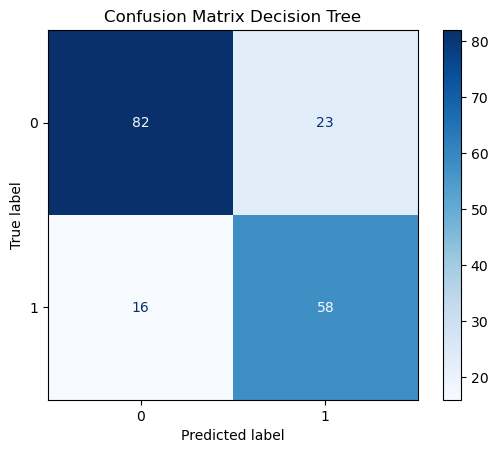

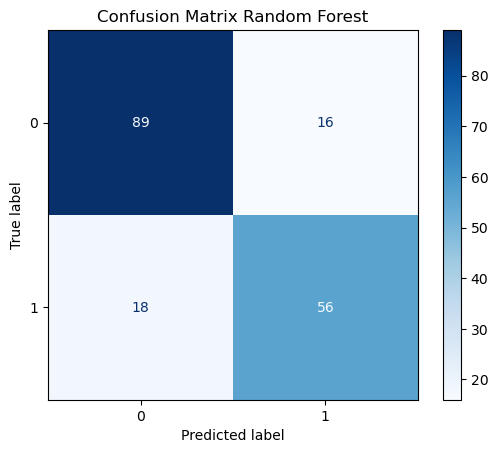

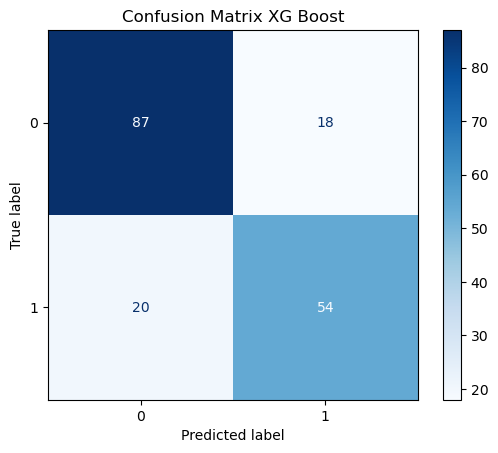

In [41]:
# Konfusionsmatrix für erstes Modell
conf_matrix = confusion_matrix(y_test, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Decision Tree')
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Random Forest')
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix XG Boost')
plt.show()

In [42]:
# Berechnen der Metriken für jede Klasse und zusammengefasst
report1 = classification_report(y_test, y_pred1, target_names=['Gestorben', 'Überlebt'])

# Drucken des Berichts
print("Klassifikationsbericht Entscheidungsbaum")
print(report1)

# Berechnen der Metriken für jede Klasse und zusammengefasst
report2 = classification_report(y_test, y_pred2, target_names=['Gestorben', 'Überlebt'])

# Drucken des Berichts
print("Klassifikationsbericht Random Forest")
print(report2)

# Berechnen der Metriken für jede Klasse und zusammengefasst
report3 = classification_report(y_test, y_pred3, target_names=['Gestorben', 'Überlebt'])

# Drucken des Berichts
print("Klassifikationsbericht XG Boost")
print(report3)

Klassifikationsbericht Entscheidungsbaum
              precision    recall  f1-score   support

   Gestorben       0.84      0.78      0.81       105
    Überlebt       0.72      0.78      0.75        74

    accuracy                           0.78       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.78      0.78       179

Klassifikationsbericht Random Forest
              precision    recall  f1-score   support

   Gestorben       0.83      0.85      0.84       105
    Überlebt       0.78      0.76      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Klassifikationsbericht XG Boost
              precision    recall  f1-score   support

   Gestorben       0.81      0.83      0.82       105
    Überlebt       0.75      0.73      0.74        74

    accuracy                           0.79       179
   macro avg      

### Tuning Entscheidungsbaum

In [68]:
# Parameterbereich für GridSearch
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'random_state': [1]  # Setzen des Seeds für den Decision Tree
}

In [69]:
# Erstellen des Klassifikators fürs Tuning
model = tree.DecisionTreeClassifier()

In [70]:
# Erstellen des GridSearchCV-Objekts
grid_search_dt = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1', verbose=1)  

In [71]:
# Modelltuning
grid_search_dt.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20],
                         'random_state': [1]},
             scoring='f1', verbose=1)

In [72]:
# Beste Parameter und beste Schätzung ausgeben
print("Beste Parameter:", grid_search_dt.best_params_)
print("Bestes Modell:", grid_search_dt.best_estimator_)

Beste Parameter: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'random_state': 1}
Bestes Modell: DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=1)


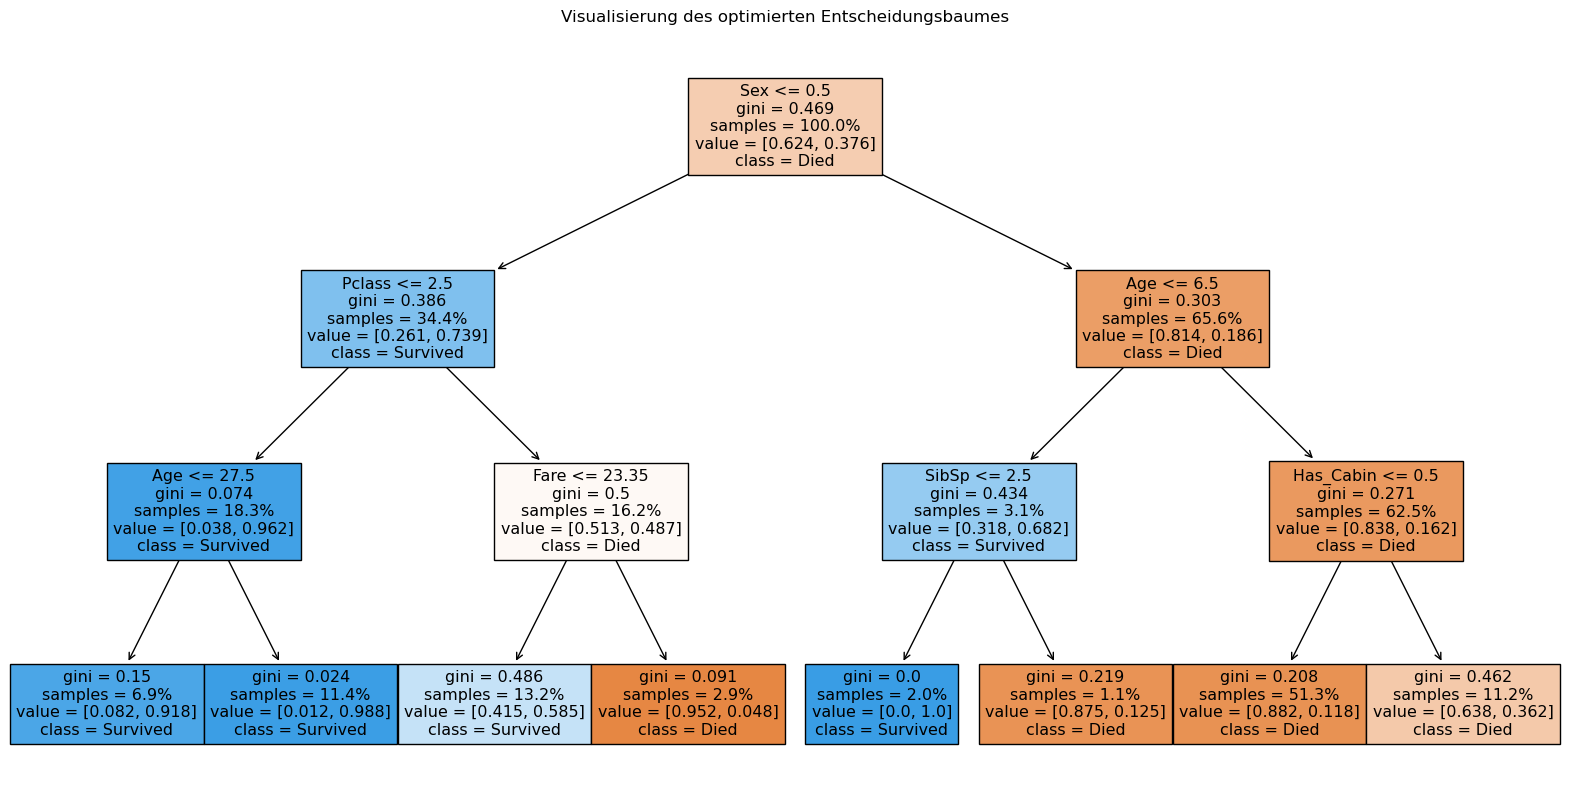

In [73]:
# Visualisieren des Entscheidungsbaumes
plt.figure(figsize=(20, 10))
tree.plot_tree(grid_search_dt.best_estimator_, filled=True, feature_names=X_train.columns.tolist(), class_names=['Died', 'Survived'], proportion=True)
plt.title('Visualisierung des optimierten Entscheidungsbaumes')
plt.show()

In [74]:
# Vorhersagen mit dem besten Modell
y_pred_best = grid_search_dt.best_estimator_.predict(X_test)

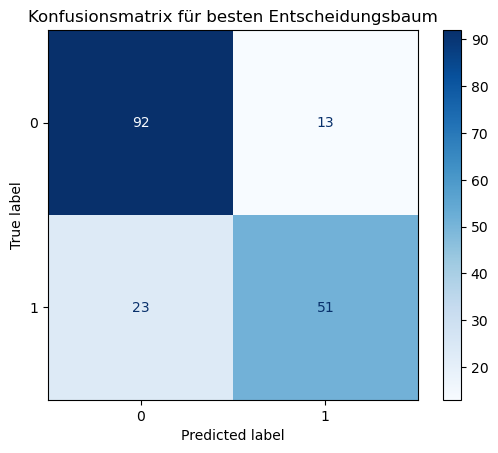

In [75]:
# Konfusionsmatrix für bestes Modell
conf_matrix = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Konfusionsmatrix für besten Entscheidungsbaum')
plt.show()

In [76]:
# Ausführlicher Bericht für bestes Modell
report = classification_report(y_test, y_pred_best, target_names=['Died', 'Survived'])
print("Klassifikationsbericht für besten Entscheidungsbaum:\n", report)

Klassifikationsbericht für besten Entscheidungsbaum:
               precision    recall  f1-score   support

        Died       0.80      0.88      0.84       105
    Survived       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



### Tuning Random Forest

In [77]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [1]
}

# Erstellen und Trainieren des GridSearchCV-Objekts
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=1)
grid_search_rf.fit(X_train, y_train)

# Ausgeben der besten Hyperparameter und des besten Modells
print("Beste Hyperarameter für Random Forest:", grid_search_rf.best_params_)
print("Bestes Random Forest Modell:", grid_search_rf.best_estimator_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Beste Hyperarameter für Random Forest: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 1}
Bestes Random Forest Modell: RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=1)


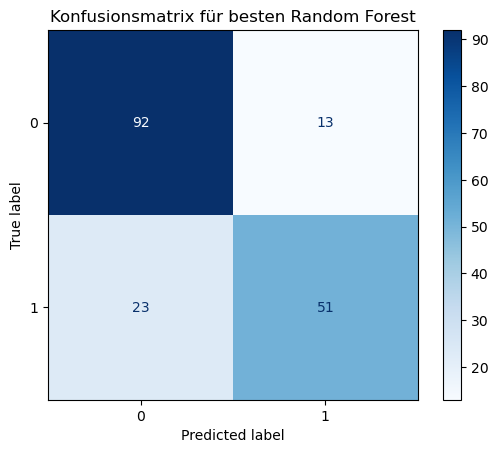

Klassifikationsbericht für besten Random Forest:
               precision    recall  f1-score   support

        Died       0.80      0.88      0.84       105
    Survived       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [78]:
# Vorhersagen mit dem besten Modell
y_pred_best_rf = grid_search_rf.best_estimator_.predict(X_test)

# Konfusionsmatrix für bestes Modell
conf_matrix = confusion_matrix(y_test, y_pred_best_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Konfusionsmatrix für besten Random Forest')
plt.show()

# Ausführlicher Bericht für bestes Modell
report = classification_report(y_test, y_pred_best_rf, target_names=['Died', 'Survived'])
print("Klassifikationsbericht für besten Random Forest:\n", report)

### Tuning XG Boost

In [79]:
# Definieren Sie das Parameterraster für GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# Erstellen und Trainieren des GridSearchCV-Objekts
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=1)
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search_xgb.fit(X_train, y_train)

# Ausgeben der besten Hyperparameter und des besten Modells
print("Beste Parameter:", grid_search_xgb.best_params_)
print("Bestes Modell:", grid_search_xgb.best_estimator_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Beste Parameter: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Bestes Modell: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)


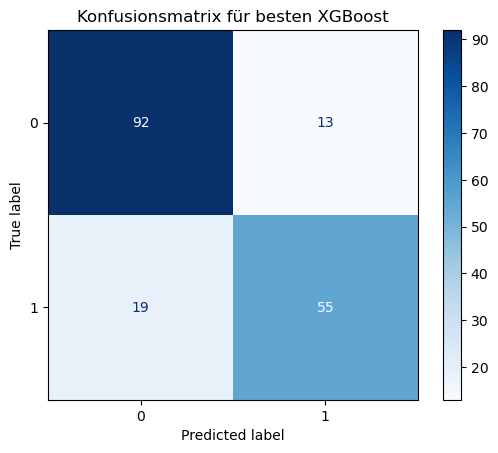

Klassifikationsbericht für besten XGBoost:
               precision    recall  f1-score   support

   Gestorben       0.83      0.88      0.85       105
    Überlebt       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [80]:
# Vorhersagen mit dem besten Modell
y_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test)

# Konfusionsmatrix für bestes Modell
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Konfusionsmatrix für besten XGBoost')
plt.show()

# Ausführlicher Bericht für bestes Modell
report_xgb = classification_report(y_test, y_pred_xgb, target_names=['Gestorben', 'Überlebt'])
print("Klassifikationsbericht für besten XGBoost:\n", report_xgb)

## Feature Importance

In [133]:
# Beste Modelle aus grid_search
best_dt = grid_search.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_xgb = grid_search_xgb.best_estimator_

In [134]:
# Feature Importance für das beste Entscheidungsbaummodell
importances_dt_best = best_dt.feature_importances_
indices_dt_best = np.argsort(importances_dt_best)[::-1]

# Feature Importance für das beste RandomForest Modell
importances_rf_best = best_rf.feature_importances_
indices_rf_best = np.argsort(importances_rf_best)[::-1]

# Feature Importance für das beste XGBoost Modell
importances_xgb_best = best_xgb.feature_importances_
indices_xgb_best = np.argsort(importances_xgb_best)[::-1]

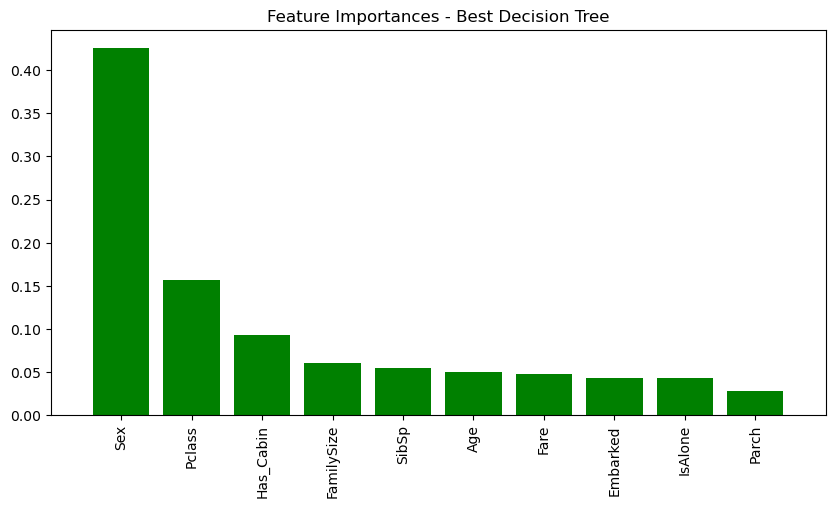

In [135]:
# Plot für beste Decision Tree Feature Importance
plt.figure(figsize=(10, 5))
plt.title('Feature Importances - Best Decision Tree')
plt.bar(range(X_train.shape[1]), importances_dt_best[indices_dt_best], color="g", align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices_dt_best], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

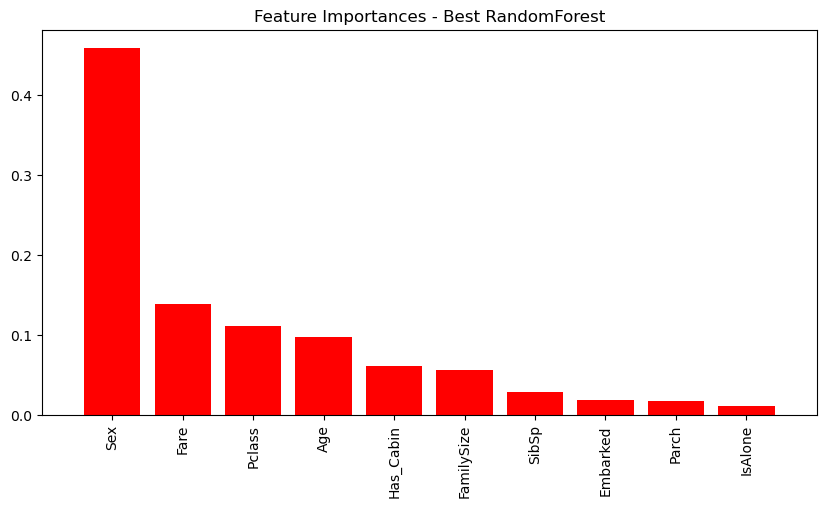

In [136]:
# Plot für beste RandomForest Feature Importance
plt.figure(figsize=(10, 5))
plt.title('Feature Importances - Best RandomForest')
plt.bar(range(X_train.shape[1]), importances_rf_best[indices_rf_best], color="r", align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices_rf_best], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

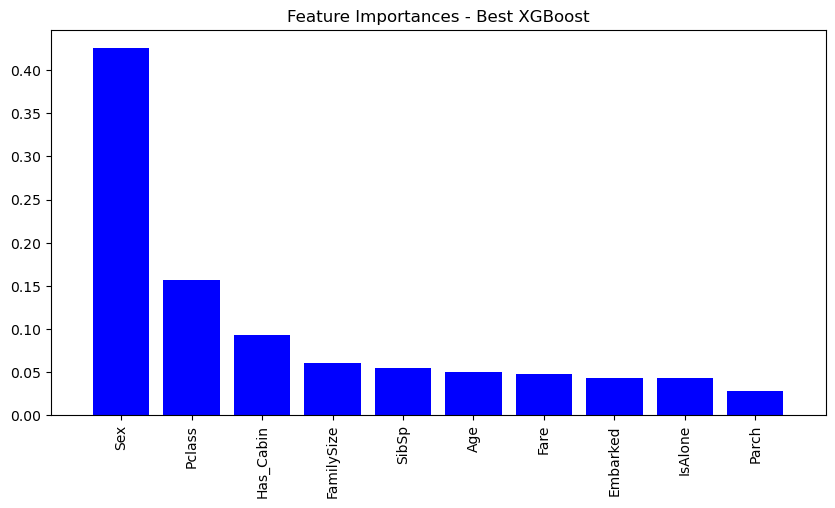

In [137]:
# Plot für beste XGBoost Feature Importance
plt.figure(figsize=(10, 5))
plt.title('Feature Importances - Best XGBoost')
plt.bar(range(X_train.shape[1]), importances_xgb_best[indices_xgb_best], color="b", align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices_xgb_best], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### SHAP

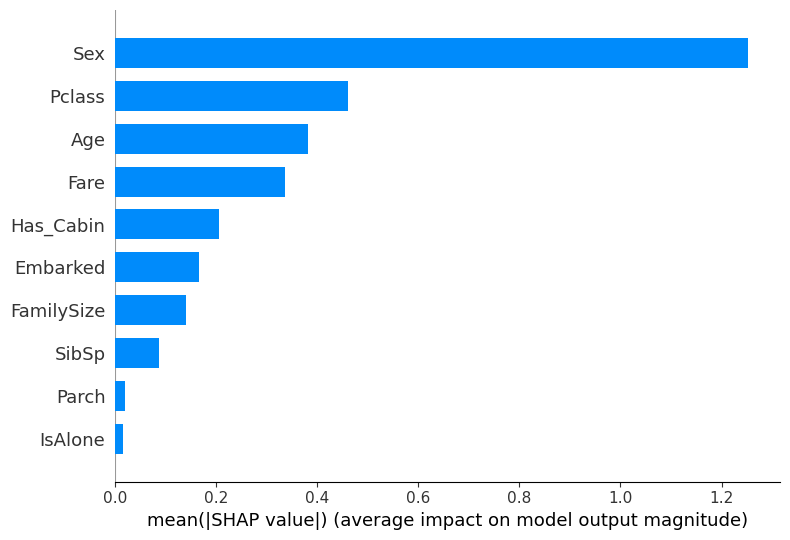

In [100]:
# SHAP-Werte für das beste Entscheidungsbaummodell
explainer_dt = shap.TreeExplainer(best_dt)
shap_values_dt = explainer_dt.shap_values(X_train)

# SHAP-Zusammenfassungsplot für den Entscheidungsbaum
shap.summary_plot(shap_values_dt, X_train, plot_type="bar")

In [131]:
# Stelle sicher, dass du dein RandomForest-Modell und Trainingsdaten als best_rf und X_train geladen hast
explainer_rf = shap.TreeExplainer(best_rf)
shap_values_rf = explainer_rf.shap_values(X_train)

# Visualisierung der SHAP-Werte
#shap.summary_plot(shap_values_rf, X_train, plot_type="bar")


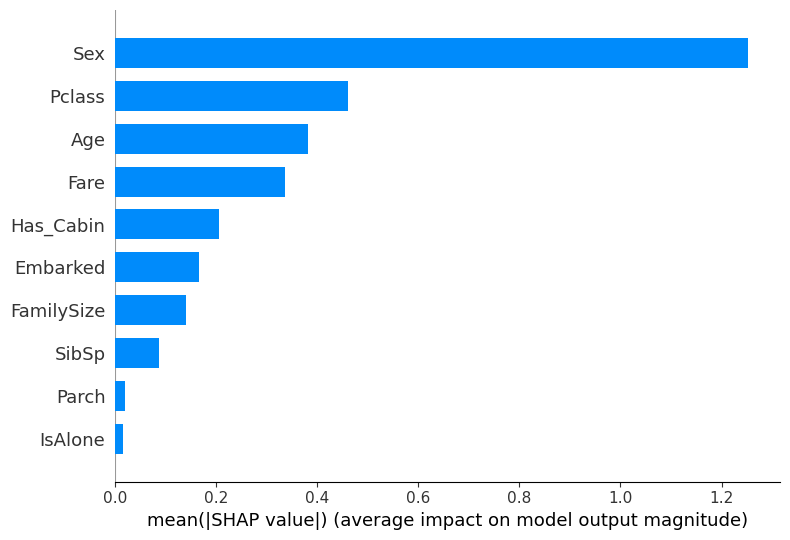

In [102]:
# SHAP-Werte für das beste XGBoost-Modell
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_train)

# SHAP-Zusammenfassungsplot
shap.summary_plot(shap_values_xgb, X_train, plot_type="bar")

### LIME

In [114]:
i=9

In [115]:
X_test.iloc[i]

Pclass         1.0000
Sex            0.0000
Age           19.0000
SibSp          0.0000
Parch          2.0000
Fare          26.2833
Embarked       0.0000
Has_Cabin      1.0000
FamilySize     3.0000
IsAlone        0.0000
Name: 136, dtype: float64

In [116]:
# LIME-Explainer für den Entscheidungsbaum
explainer_lime_dt = LimeTabularExplainer(training_data=np.array(X_train),
                                         feature_names=X_train.columns,
                                         class_names=['Gestorben', 'Überlebt'],
                                         mode='classification')

# Erklärung für eine einzelne Vorhersage aus dem Entscheidungsbaummodell

exp_dt = explainer_lime_dt.explain_instance(X_test.iloc[i], best_dt.predict_proba, num_features=5)
exp_dt.show_in_notebook(show_table=True)


In [117]:
# LIME-Explainer für RandomForest initialisieren
explainer_lime_rf = LimeTabularExplainer(training_data=np.array(X_train),
                                         feature_names=X_train.columns,
                                         class_names=['Gestorben', 'Überlebt'],
                                         mode='classification',
                                         training_labels=y_train)

# Erklärung für eine einzelne Vorhersage aus dem RandomForest-Modell

exp_rf = explainer_lime_rf.explain_instance(X_test.iloc[i], best_rf.predict_proba, num_features=5)
exp_rf.show_in_notebook(show_table=True)

C:\Users\hubersi\.conda\envs\stamo24\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [118]:
# LIME-Explainer initialisieren
explainer_lime = LimeTabularExplainer(training_data=np.array(X_train),
                                      feature_names=X_train.columns,
                                      class_names=['Gestorben', 'Überlebt'],
                                      mode='classification')

# Erklärung für eine einzelne Vorhersage

exp = explainer_lime.explain_instance(X_test.iloc[i], best_xgb.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True)
